<a href="https://colab.research.google.com/github/Liu22Yi/EPID_592_code/blob/main/Yi_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


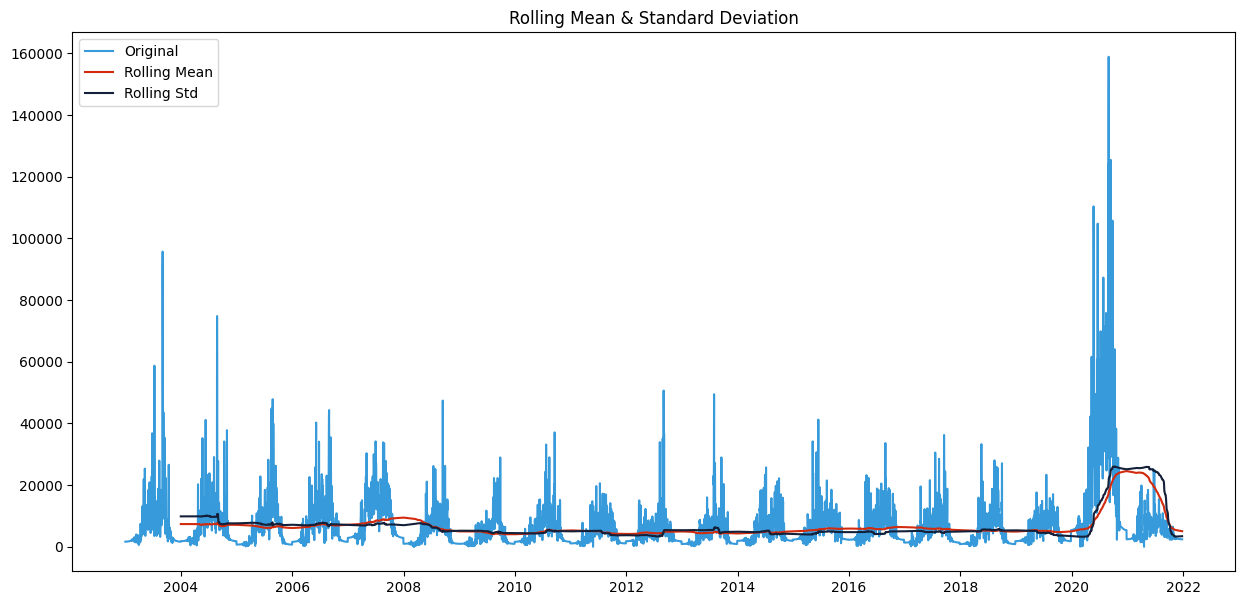

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
!pip install pmdarima==2.0.2
import pmdarima as pm

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Research/ks_imp.csv")

# Delete the first column
df = df.iloc[:, 1:]

# Get the number of rows and columns
num_rows = df.shape[0]
num_cols = df.shape[1]

# Reshape the DataFrame into a 2D NumPy array with one column
df_time = np.reshape(df.values, (num_rows * num_cols, 1))

# Convert the reshaped data to a Pandas DataFrame to ensure proper type conversion
df_time = pd.DataFrame(df_time, columns=['Value'])

# Convert all values to numeric, coercing errors (non-numeric values become NaN)
df_time['Value'] = pd.to_numeric(df_time['Value'], errors='coerce')

# Create the date range
start_date = datetime(2003, 1, 1)
end_date = datetime(2021, 12, 31)
date_range = pd.date_range(start_date, end_date, freq='D')

# Ensure the length of date_range matches df_time
date_range = date_range[:len(df_time)]

# Create a Pandas Series with the reshaped data and datetime index
df_time_series = pd.Series(df_time['Value'].values, index=date_range, name='Value')

# Calculate rolling statistics with a window of 365 days
rolling_avg = df_time_series.rolling(window=365).mean()
rolling_std = df_time_series.rolling(window=365).std()

# Plot rolling statistics
plt.figure(figsize=(15, 7))
plt.plot(df_time_series, color='#379BDB', label='Original')
plt.plot(rolling_avg, color='#D22A0D', label='Rolling Mean')
plt.plot(rolling_std, color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [ ]:
# Augmented Dickey–Fuller test
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_time_series.dropna(), autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -5.358144
p-value                           0.000004
#Lags Used                       29.000000
Number of Observations Used    6905.000000
Critical Value (1%)              -3.431297
Critical Value (5%)              -2.861959
Critical Value (10%)             -2.566993
dtype: float64


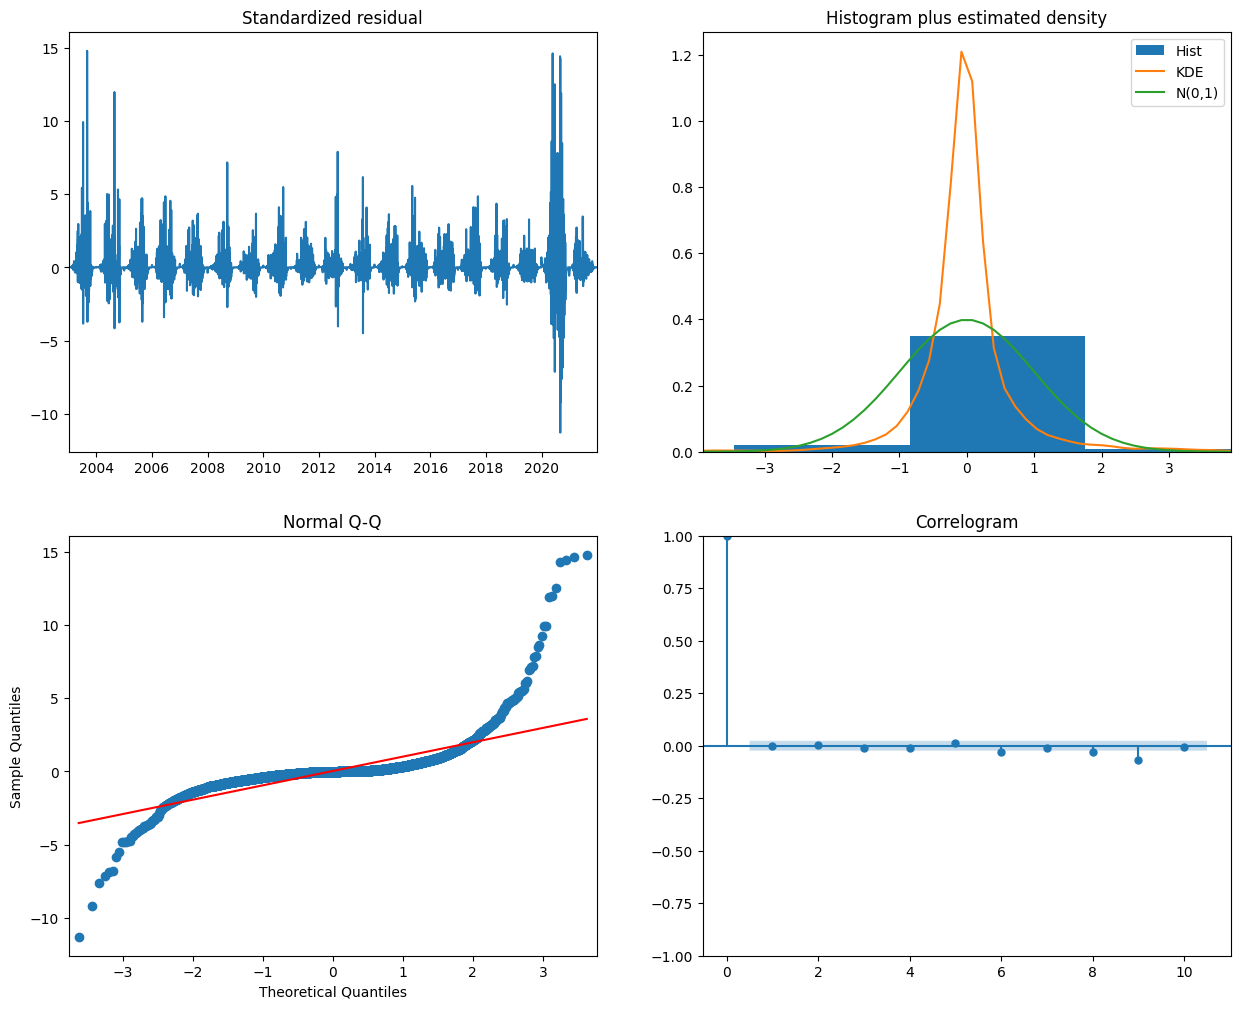

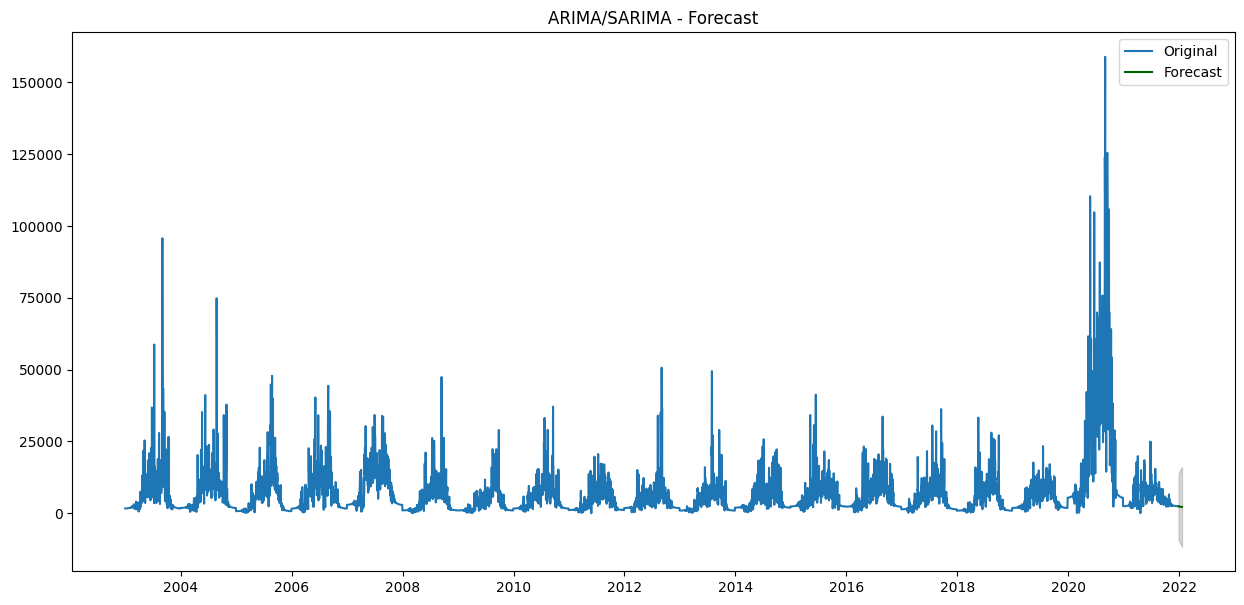

In [ ]:
# Standard ARIMA Model
ARIMA_model = pm.auto_arima(df_time_series.dropna(),
                            start_p=1,
                            start_q=1,
                            test='adf',  # use adftest to find optimal 'd'
                            max_p=3, max_q=3,  # maximum p and q
                            m=1,  # frequency of series (if m==1, seasonal is set to FALSE automatically)
                            d=None,  # let model determine 'd'
                            seasonal=False,  # No Seasonality for standard ARIMA
                            trace=False,  # logs
                            error_action='warn',  # shows errors ('ignore' silences these)
                            suppress_warnings=True,
                            stepwise=True)

ARIMA_model.plot_diagnostics(figsize=(15, 12))
plt.show()

def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df_time_series.index[-1] + pd.DateOffset(days=1), periods=n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15, 7))
    plt.plot(df_time_series, color='#1f76b4', label='Original')
    plt.plot(fitted_series, color='darkgreen', label='Forecast')
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=.15)
    plt.legend(loc='best')
    plt.title("ARIMA/SARIMA - Forecast")
    plt.show()

forecast(ARIMA_model)

In [ ]:
# Define the fraction of the data to use
subset_fraction = 0.1
subset_length = int(len(df_time_series) * subset_fraction)

# Select the first 10% of the data
df_time_series_subset = df_time_series.iloc[:subset_length]

# Seasonal - fit stepwise auto-ARIMA on the subset
SARIMA_model_subset = pm.auto_arima(df_time_series_subset.dropna(), start_p=1, start_q=1,
                                    test='adf',
                                    max_p=2, max_q=2,
                                    m=365,  # Annual seasonality for daily data
                                    start_P=0, max_P=1,
                                    start_Q=0, max_Q=1,
                                    seasonal=True,
                                    d=None,
                                    D=1,
                                    trace=False,
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=True)

SARIMA_model_subset.plot_diagnostics(figsize=(15, 12))
plt.show()

forecast(SARIMA_model_subset)

KeyboardInterrupt: 

# LSTM

Epoch 0, Loss: 0.0025240867398679256, Test Loss: 0.011427673511207104
Epoch 10, Loss: 0.0013782179448753595, Test Loss: 0.01021507102996111
Epoch 20, Loss: 0.0011997781693935394, Test Loss: 0.008350647054612637
Epoch 30, Loss: 0.0010270258644595742, Test Loss: 0.006583239883184433
Epoch 40, Loss: 0.0008144441526383162, Test Loss: 0.004615236073732376
Epoch 50, Loss: 0.0007342573371715844, Test Loss: 0.0033096226397901773
Epoch 60, Loss: 0.0007395600550808012, Test Loss: 0.003246504347771406
Epoch 70, Loss: 0.0007235832163132727, Test Loss: 0.0034513515420258045
Epoch 80, Loss: 0.0007234863587655127, Test Loss: 0.003540009493008256
Epoch 90, Loss: 0.000720578245818615, Test Loss: 0.0034378529526293278


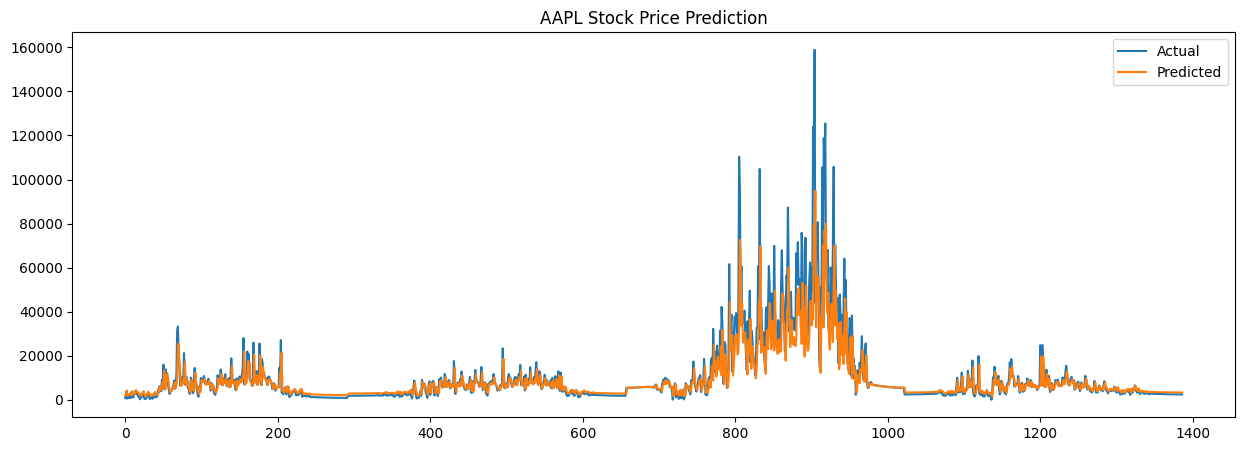

Mean Squared Error: 85958056.77793345


In [ ]:
# Import necessary libraries
import yfinance as yf
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Use the 'Close' price for prediction
close_prices = df_time

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices.reshape(-1, 1))

# Prepare the dataset
X = close_prices_scaled[:-1]
y = close_prices_scaled[1:]

# Reshape for LSTM
X = X.reshape(-1, 1, 1)
y = y.reshape(-1, 1)



#manually avoid the data leakage
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# LSTM with Attention Mechanism
class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTMAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attention_weights = torch.softmax(self.attention(lstm_out).squeeze(-1), dim=-1)
        context_vector = torch.sum(lstm_out * attention_weights.unsqueeze(-1), dim=1)
        out = self.fc(context_vector)
        return out

# Instantiate and train the model
model = LSTMAttention(input_dim=1, hidden_dim=50)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model.eval()
        test_pred = model(X_test_tensor)
        test_loss = criterion(test_pred, y_test_tensor)
        print(f'Epoch {epoch}, Loss: {loss.item()}, Test Loss: {test_loss.item()}')

# Predictions
model.eval()
predictions = model(X_test_tensor).detach().numpy()
predictions_actual = scaler.inverse_transform(predictions)

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(scaler.inverse_transform(y_test), label='Actual')
plt.plot(predictions_actual, label='Predicted')
plt.title('AAPL Stock Price Prediction')
plt.legend()
plt.show()

# Calculate MSE
mse = mean_squared_error(scaler.inverse_transform(y_test), predictions_actual)
print(f'Mean Squared Error: {mse}')

In [ ]:
mean_daily_value = df.mean()
print(mean_daily_value)

V1      1808.203738
V2      1808.443128
V3      1809.161623
V4      1810.359517
V5      1812.037301
           ...     
V361    1814.199063
V362    1812.039285
V363    1810.360648
V364    1809.162260
V365    1808.443483
Length: 365, dtype: float64


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Step 2: Calculate the mean of the training set
mean_train = train_df.mean()

# Step 3: Use this mean to predict the values in the testing set
predictions = pd.DataFrame(np.tile(mean_train, (test_df.shape[0], 1)), columns=test_df.columns)

# Step 4: Compute the squared error for each prediction in the testing set
squared_errors = (test_df - predictions) ** 2

# Step 5: Calculate the average squared error for the testing set
average_squared_error = squared_errors.mean().mean()

print("Mean of Training Set:\n", mean_train)
print("Average Squared Error on Test Set:", average_squared_error)

Mean of Training Set:
 V1      1866.237495
V2      1866.482613
V3      1867.218299
V4      1868.444851
V5      1870.162766
           ...     
V361    1872.376205
V362    1870.164785
V363    1868.446002
V364    1867.218948
V365    1866.482974
Length: 365, dtype: float64
Average Squared Error on Test Set: 53772995.91121695
